# Setup

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from IPython.display import display

pd.options.mode.chained_assignment = None  # default='warn'

# Function definitions

In [ ]:
def visualize_stock_history(df, vol_window, trading_days):
    """hello, documentation maybe
    """
    
    plt.figure()
    plt.plot(df.Close)
    plt.title("Daily stock closing price")
    plt.plot()

    plt.figure()
    plt.plot(df.Close-df.Open)
    plt.title("Daily stock price change (Close-Open)")
    plt.plot()

    plt.figure()
    plt.plot(df.High-df.Low)
    plt.title("Daily stock maximum spread (High-Low)")
    plt.plot()

    plt.figure()
    plt.plot(df.Volume)
    plt.title("Daily stock trade volume")
    plt.plot()
    
    vol = df.Close.pct_change().rolling(vol_window).std()*(trading_days**0.5)
    plt.figure()
    plt.plot(vol)
    plt.title( str(vol_window) + " days historical volatility (annualised)")
    plt.show()
    
    if not all(df.Dividends == 0):
        
        plt.figure()
        plt.plot(df.Dividends)
        plt.title("Historical dividends")
        plt.show()
        
    if not all(df["Stock Splits"] == 0):
        
        plt.figure()
        plt.plot(df["Stock Splits"])
        plt.title("Historical stock splits")
        plt.show()
    

In [ ]:
def show_company_fundamentals(ticker):    
    # show major holders
    display(ticker.major_holders)

    # show institutional holders
    display(ticker.institutional_holders.head())

    # show sustainability
    display(ticker.sustainability[~ticker.sustainability.Value.isin([False, None])])

    # show financials, if the data exists (is financials = balance sheet, cash flow and earnings?)
    if len(ticker.financials > 0):
        display(ticker.financials)
        display(ticker.quarterly_financials)

    if len(ticker.balance_sheet > 0):
        display(ticker.balance_sheet)
        display(ticker.quarterly_balance_sheet)

    if len(ticker.cashflow > 0):
        display(ticker.cashflow)
        display(ticker.quarterly_cashflow)

    if len(ticker.earnings > 0):
        display(ticker.earnings)
        display(ticker.quarterly_earnings)

In [ ]:
def analyst_recommendations(ticker):
    rec_df = ticker.recommendations
    rec_df = rec_df.loc[rec_df["To Grade"] != ""]
    grade_vec = rec_df["To Grade"]

    map_to_1 = ['Buy', 'Positive']
    map_to_2 = ['Outperform', 'Overweight', 'Market Outperform']
    map_to_3 = ['Hold', 'Neutral', 'Equal-Weight', 'Market Perform', 'Sector Perform', \
                'Perform', 'Sector Weight', 'Peer Perform', 'In-Line']
    map_to_4 = ['Underperform', 'Underweight', 'Market Underperform', 'Underperformer']
    map_to_5 = ['Sell']

    my_dict = {}
    my_dict.update(dict.fromkeys(map_to_1, 1))
    my_dict.update(dict.fromkeys(map_to_2, 2))
    my_dict.update(dict.fromkeys(map_to_3, 3))
    my_dict.update(dict.fromkeys(map_to_4, 4))
    my_dict.update(dict.fromkeys(map_to_5, 5))
    
    grade_vec = grade_vec.map(my_dict).astype(int)
    rec_df["Grade"] = grade_vec
    df1 = rec_df[rec_df.isna().any(axis=1)]
    if len(df1) > 0:
        print("Some ratings were undefined")
        display(df1)
        rec_df = rec_df.dropna()
    
    tmp = rec_df.copy()
    tmp = tmp.drop(["Firm", "To Grade", "From Grade", "Action"], axis = 1)
    tmp.Grade = tmp.Grade.astype(int)
    # print(tmp.dtypes)
    tmp = tmp.to_period('M').groupby(pd.Grouper(freq="Q")).mean()
    tmp = tmp.dropna(axis = 0)
    tmp.index = tmp.index.to_timestamp()

    plt.figure(figsize = (15, 5))
    plt.plot(rec_df.Grade, '.-', label = "Stock rating")
    plt.plot(tmp.index, tmp.Grade, 'o-', label = "Quarterly rating", linewidth = 2.5)
    plt.title("An overview over changes in stock rating")
    plt.yticks(range(1, 5))
    plt.gca().invert_yaxis()
    plt.legend()
    plt.show()

## Options analysis functions

In [ ]:
def call_put_visualisation(stock_ref):
    """Visualize call/put volumes and ITM fractions for all upcoming expiry dates 
    """
    
    options_expiry = stock_ref.options
    call_frac_ITM = []
    put_frac_ITM = []
    call_vols = []
    put_vols = []

    for exp_date in options_expiry:
        options = stock_ref.option_chain(exp_date)

        puts_df = options.puts
        calls_df = options.calls

        # Check volume of call/put options by expiration 
        call_vol = calls_df.volume.sum()
        put_vol = puts_df.volume.sum()
        call_vols.append(call_vol)
        put_vols.append(put_vol)

        # Check fraction of options that are in/out of the money
        sum_ITM = puts_df[puts_df.inTheMoney == True].volume.sum()
        sum_OTM = puts_df[puts_df.inTheMoney == False].volume.sum()
        if sum_ITM == 0 and sum_OTM == 0:
            frac_ITM = 0
        else:     
            frac_ITM = sum_ITM / (sum_ITM + sum_OTM)
        put_frac_ITM.append(frac_ITM)

        sum_ITM = calls_df[calls_df.inTheMoney == True].volume.sum()
        sum_OTM = calls_df[calls_df.inTheMoney == False].volume.sum()
        if sum_ITM == 0 and sum_OTM == 0:
            frac_ITM = 0
        else:     
            frac_ITM = sum_ITM / (sum_ITM + sum_OTM)
        call_frac_ITM.append(frac_ITM)

    plt.figure(figsize = (12, 5))
    plt.plot(options_expiry, call_vols, 'o-', label = "Total call option volume")
    plt.plot(options_expiry, put_vols, 'o-', label = "Total put option volume")
    plt.xticks(rotation = 45)
    plt.title("Option volumes vs expiry date")
    plt.legend()
    plt.show()

    plt.figure(figsize = (12, 5))
    plt.plot(options_expiry, call_frac_ITM, 'o-', label = "Calls ITM")
    plt.plot(options_expiry, put_frac_ITM, 'o-', label = "Puts ITM")
    plt.xticks(rotation = 45)
    plt.title("Fraction of Call and Put contract that are ITM, based on expiry date")
    plt.legend()
    plt.show()

In [ ]:
def single_expiry_plot(df, exp_date, title_string):
    
    df["spread"] = df.ask - df.bid
    plot_max = max(max(df.spread), max(df.impliedVolatility))

    if (puts_df.contractSize.unique()[0] != "REGULAR"): 
        print(exp_date)
        print(puts_df.contractSize.value_counts())

    plt.plot(df.strike, df.spread, label = "Bid-Ask spread")
    plt.plot(df.strike, df.impliedVolatility, label = "Implied Vol")
    plt.vlines(prev_stock_val, 0, plot_max, label = "Last close val")
    plt.title(title_string + " option characteristics for different strikes: " + str(exp_date))
    plt.legend()    

def option_spread_analysis(ticker):
    prev_stock_val = ticker.info.get("previousClose") # most recent stock closing value

    for exp_date in ticker.options:

        opt = ticker.option_chain(exp_date)
        puts_df = opt.puts
        calls_df = opt.calls
        puts_df = puts_df[puts_df.volume.notna()]
        calls_df = calls_df[calls_df.volume.notna()]
        
        if len(puts_df) > 0 and len (calls_df) > 0:
            
            plt.figure(figsize=(16, 5))
            plt.subplot(1, 2, 1)
            title_string = "Put"
            single_expiry_plot(puts_df, exp_date, title_string)

            plt.subplot(1, 2, 2)
            title_string = "Call"
            single_expiry_plot(calls_df, exp_date, title_string)
            plt.show()

# SP500 stocks

In [2]:
# shift + tab to get function documentation
SP500_df = pd.read_csv("constituents.csv")
SP500_df.Sector.value_counts()

Industrials               73
Information Technology    71
Financials                66
Health Care               62
Consumer Discretionary    61
Consumer Staples          33
Real Estate               31
Materials                 28
Utilities                 28
Communication Services    26
Energy                    26
Name: Sector, dtype: int64

In [12]:
#start_date = "2020-01-01"
#end_date = "2020-07-01"

company_list = SP500_df[SP500_df.Sector == "Consumer Discretionary"].Symbol
test = yf.Tickers(["GS", "TSLA"])
test_df = test.history(period = "1y")
#test_df = test.history(start=start_date, end=end_date)

[*********************100%***********************]  2 of 2 completed


In [10]:
test_df.head()

Close            Dividends             High             \
                    GS       TSLA        GS TSLA          GS       TSLA   
Date                                                                      
2019-10-14  200.942001  51.391998       0.0    0  201.283697  51.709999   
2019-10-15  201.566833  51.577999       0.0    0  203.304646  52.000000   
2019-10-16  202.504074  51.950001       0.0    0  203.675631  52.419998   
2019-10-17  201.566833  52.394001       0.0    0  203.978280  52.956001   
2019-10-18  201.625427  51.389999       0.0    0  203.128922  52.560001   

                   Low                   Open            Stock Splits       \
                    GS       TSLA          GS       TSLA           GS TSLA   
Date                                                                         
2019-10-14  198.110723  49.425999  198.999160  49.580002            0  0.0   
2019-10-15  193.902875  50.824001  197.212530  51.540001            0  0.0   
2019-10-16  201.215366  51.383999  201.283700  51.478001            0  0.0   
2019-10-17  199.545886  52.034000  203.353449  52.500000            0  0.0   
2019-10-18  200.131690  51.020000  200.131690  52.139999            0  0.0   

             Volume            
                 GS      TSLA  
Date                           
2019-10-14  2286100  51025000  
2019-10-15  8241900  32164000  
2019-10-16  3405800  33420500  
2019-10-17  2876500  23846500  
2019-10-18  2207000  28749000

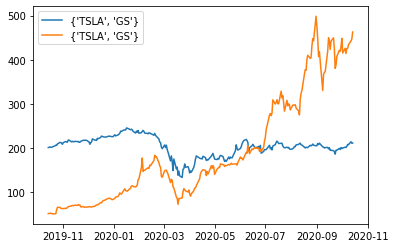

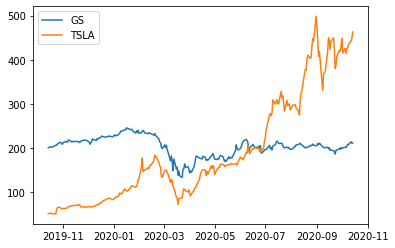

In [22]:
plt.plot(test_df.Close, label = {"GS", "TSLA"})
plt.legend()
plt.show()

x = test_df.index
y = [test_df.Close.GS, test_df.Close.TSLA]
labels = ["GS", "TSLA"]

plt.figure()
for y_arr, label in zip(y, labels):
    plt.plot(x, y_arr, label=label)

plt.legend()
plt.show()

In [24]:
test_df.Close.to_series()

AttributeError: 'DataFrame' object has no attribute 'to_series'

# Stock intro

In [ ]:
# Microsoft
msft = yf.Ticker("MSFT")
msft.info

In [ ]:
# Tesla
tsla = yf.Ticker("TSLA")
tsla_df = tsla.history(period = "max")
tsla_df.head()

# Analysis: Goldman Sachs

## Intro

In [ ]:
gs = yf.Ticker("GS")
gs_df = gs.history("max")
gs_df.head()

In [ ]:
trading_days = 252
vol_window = 20

visualize_stock_history(gs_df, vol_window, trading_days)

# could use ARIMA/GARCH on the historical stock data!

# There is higher volatility around 2008, when the trading volumes are higher
# But volatility has also increased recently independently of trading volumes (Corona)
# analyse corona behaviour compared to '08 crisis

In [ ]:
show_company_fundamentals(gs)

# peer groups are interesting! could look at if they do outperform their peers, or not!
# can I get a list of all tickers within a certain peer group?

In [ ]:
# show next event (earnings, etc)
gs.calendar

## Recommendations analysis

In [ ]:
analyst_recommendations(tsla)

In [ ]:
# here is a df with ratings, only looking at when we have a definitive "up" or "down"
# analyse this more - when/how often/average rating changes, and how that relates to past and future stock movements

tsla_rec = tsla.recommendations
action_list = ["up", "down"]
updown_df = tsla_rec.loc[tsla_rec.Action.isin(action_list)]
updown_df.Action.value_counts()

In [ ]:
updown_df[updown_df.Action == "down"]
updown_df.Action.map(action_dict)

In [ ]:
action_dict = {"down" : -1, "up" : 1}
tmp = updown_df.Action.map(action_dict)
tmp = tmp.to_period('M').groupby(pd.Grouper(freq="Q")).mean()     # can also get std dev
tmp = tmp.dropna(axis = 0)
tmp.index = tmp.index.to_timestamp()

plt.figure(figsize=(15, 5))
plt.plot(tmp, 'o-', label = "Average change")
plt.title("Quarterly rating change. 1 = up, -1 = down ")
plt.legend()
plt.show()

In [ ]:
tmp = updown_df.Action.map(action_dict)
tmp3 = tmp.to_period('M').groupby(pd.Grouper(freq="Q")).std()
tmp3.index = tmp3.index.to_timestamp()
tmp3 = tmp3.dropna()

plt.plot(tmp3, 'o-')
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(updown_df[updown_df.Action == "down"].Action, 'o-', label = "Down")
plt.plot(updown_df[updown_df.Action == "up"].Action, 'o-', label = "Up")
plt.legend()
plt.show()

In [ ]:
# use this; look for trends here. Also, how frequently a rating is changed is a sign of instability
# tesla has many ratings at 1 or 5, giving an average around 3 for the quarter! This is not representative 
# (the fact that I just use the "To rating" doesn't help) - but not all stocks have a "from rating" column
# also, is there a correlation between ratings from two institutions across different stocks? 
# Do they tend to increase ratings at same time etc?

# Which ratings agencies are best at predicting? Rating change -> check stock behaviour for one year afterwards
# and compare stock performance to its industry peers!

## Option analysis

In [ ]:
gs_options_expiry = gs.options
gs_call = gs.option_chain(gs_options_expiry[0]).calls
gs_call.head()

In [ ]:
call_put_visualisation(gs)

In [ ]:
option_spread_analysis(gs)

# Future work

In [ ]:
# how do spreads change over time wrt different trading dates? In/out of the money?
# are ratings correlated with future stock values?
# is a larger volume in put or call at any given time? do something clever here
# have a look at the implied volatility - is there a skew?
# make everything into functions and compare with other stocks!
# correlation between stocks

You can create a cell and put the following code in it:

%%html
<style>
div.input {
    display:none;
}
</style>
Running this cell will hide all input cells. To show them back, you can use the menu to clear all outputs.